# 1. Importação de Bibliotecas

In [5]:
# Importação de bibliotecas necessárias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

from collections import Counter
from wordcloud import WordCloud

# Configurações de visualização
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Baixar recursos necessários do NLTK
nltk.download('wordnet')
nltk.download('stopwords')

import warnings
warnings.filterwarnings('ignore')

import os


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\giova\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\giova\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Configurações Adicionais

In [6]:
# Definir stopwords e lematizador
lemmatizer = WordNetLemmatizer()
stop_words_en = stopwords.words('english')


# 2. Funções Auxiliares


In [7]:
def carregar_dados(file_path):
    """
    Função para carregar os dados a partir de um arquivo CSV.
    """
    try:
        df = pd.read_csv(file_path, encoding='ISO-8859-1')
        print("Dados carregados com sucesso!")
        return df
    except Exception as e:
        print(f"Erro ao carregar dados: {e}")
        return None

def limpar_descricao(descricao):
    """
    Função para limpar e normalizar as descrições dos produtos.
    """
    descricao = descricao.lower()
    descricao = re.sub(r'[^a-z\s]', '', descricao)
    palavras = descricao.split()
    palavras = [lemmatizer.lemmatize(palavra) for palavra in palavras if palavra not in stop_words_en]
    return ' '.join(palavras)

def palavras_mais_comuns(descricoes, top_n=15):
    """
    Função para encontrar as palavras mais comuns em uma lista de descrições.
    """
    todas_palavras = ' '.join(descricoes).lower()
    todas_palavras = re.findall(r'\b\w+\b', todas_palavras)
    contador_palavras = Counter(todas_palavras)
    return contador_palavras.most_common(top_n)


# 3. Carregamento e Limpeza dos Dados

In [8]:

os.chdir('..')

# Caminho do arquivo de dados
file_path = "data/raw/online_retail.csv"

# Carregar dados
df = carregar_dados(file_path)



Dados carregados com sucesso!


In [9]:
# Estrutura do DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


#### Renomeando as colunas para o português


In [10]:
# Renomear as colunas para o português
df.rename(columns={
    'InvoiceNo': 'NumeroFatura',
    'StockCode': 'CodigoProduto',
    'Description': 'Descricao',
    'Quantity': 'Quantidade',
    'InvoiceDate': 'DataFatura',
    'UnitPrice': 'PrecoUnitario',
    'CustomerID': 'IDCliente',
    'Country': 'Pais'
}, inplace=True)


In [11]:
# Checar novamente a estrutura do DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   NumeroFatura   541909 non-null  object 
 1   CodigoProduto  541909 non-null  object 
 2   Descricao      540455 non-null  object 
 3   Quantidade     541909 non-null  int64  
 4   DataFatura     541909 non-null  object 
 5   PrecoUnitario  541909 non-null  float64
 6   IDCliente      406829 non-null  float64
 7   Pais           541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [12]:
# Remover duplicatas
df.drop_duplicates(inplace=True)


In [13]:
# Checar valores ausentes
df.isna().sum()

NumeroFatura          0
CodigoProduto         0
Descricao          1454
Quantidade            0
DataFatura            0
PrecoUnitario         0
IDCliente        135037
Pais                  0
dtype: int64

In [14]:
# Preencher IDCliente nulo com 'Desconhecido'
df['IDCliente'] = df['IDCliente'].fillna('Desconhecido').astype(str)

# Preencher Descricao nula com CodigoProduto
df['Descricao'] = df.apply(
    lambda row: row['CodigoProduto'] if pd.isna(row['Descricao']) else row['Descricao'], axis=1
)

# Exibir resumo de valores nulos após o preenchimento
print("Valores nulos após o preenchimento:")
print(df.isna().sum())

Valores nulos após o preenchimento:
NumeroFatura     0
CodigoProduto    0
Descricao        0
Quantidade       0
DataFatura       0
PrecoUnitario    0
IDCliente        0
Pais             0
dtype: int64


# Abordagem para Tratamento de Valores Ausentes

## 1. Preenchimento de `IDCliente` com 'Desconhecido'
- **Motivo:** Excluir mais de 130.000 mil registros afetaria a integridade do dataset e prejudicaria as análises e previsões.
- **Estratégia:** Preencher IDs de cliente nulos com o valor **'Desconhecido'** mantém as transações intactas, mas marca registros sem identificação de cliente.
- **Impacto:** 
  - Pode ser usado em previsões de vendas e demanda.
  - Deve ser tratado de forma especial em análises de clientes (ex.: ignorado em churn ou CLV).

## 2. Preenchimento de `Descricao` com `CodigoProduto`
- **Motivo:** Produtos sem descrição podem ser identificados pelo **Código do Produto**, evitando perda de informações.
- **Estratégia:** Onde a `Descricao` estiver ausente, usamos o valor de `CodigoProduto` como substituto.
- **Impacto:** 
  - Evita perda de registros.
  - Garante que produtos estejam identificados para relatórios e análises.

## 3. Vantagens da Abordagem
- **Preserva** o maior número possível de registros.
- **Garante integridade** para previsões de demanda e análises agregadas.
- **Facilita a separação** entre transações identificadas e não identificadas para tratamento específico.


In [15]:
# Verificar duplicados no DataFrame
df.duplicated().sum()


np.int64(0)

#### Estatísticas Descritivas Básicas

In [16]:
df.describe()

,Quantidade,PrecoUnitario
count,536641.000000,536641.000000
mean,9.620029,4.632656
std,219.130156,97.233118
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


In [17]:
# Remover linhas com 'Quantidade' < 1 e 'PrecoUnitario' <= 0.10
df = df[(df['Quantidade'] >= 1) & (df['PrecoUnitario'] > 0.10)]


#### Nota: Em "Quantidade" observamos uma grande amostra de valores negativos. Como não temos informações suficientes sobre o problema de negócio, focaremos apenas em vendas efetivadas.



#### Igualmente em PrecoUnitario, observamos valores a partir de UM centavo. Entendemos que vendas realizadas com preços muito baixos são indícios de erros de digitação. Desta forma, utilizaremos somente valores acima de 0.10 centavos como relevantes para o negócio.

# 4. Análise Exploratória (EDA)

In [18]:
# Visualizar as primeiras linhas do DataFrame
df.head()


,NumeroFatura,CodigoProduto,Descricao,Quantidade,DataFatura,PrecoUnitario,IDCliente,Pais
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [19]:
df.describe()

,Quantidade,PrecoUnitario
count,524578.000000,524578.000000
mean,10.551054,3.924778
std,156.157893,36.103229
min,1.000000,0.120000
25%,1.000000,1.250000
50%,4.000000,2.080000
75%,11.000000,4.130000
max,80995.000000,13541.330000


#### 4.1. Visualização de Outliers

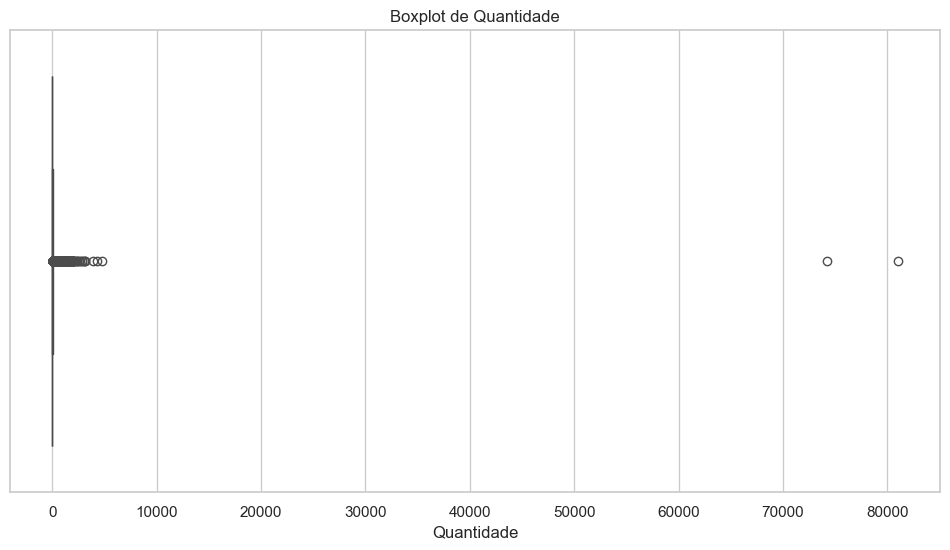

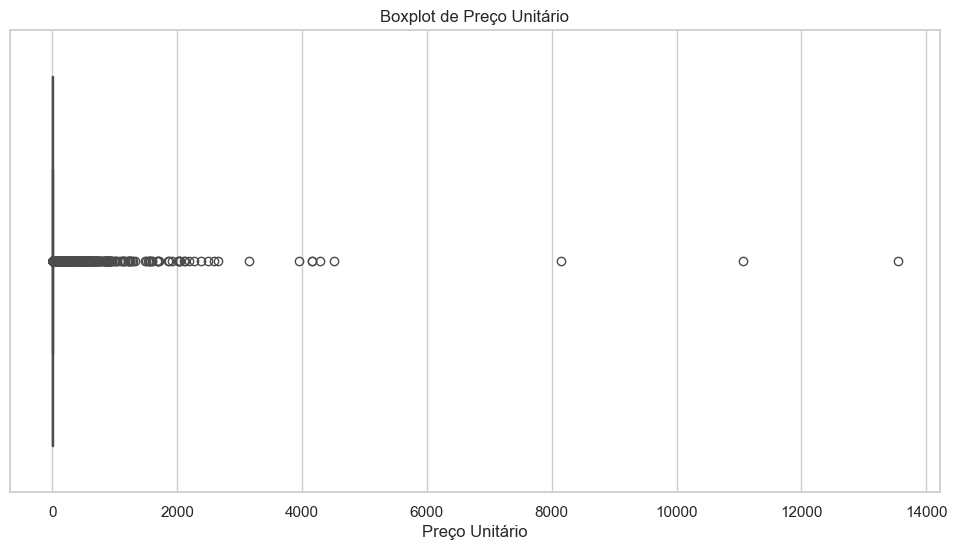

In [20]:
# Visualização de outliers na coluna Quantidade
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['Quantidade'])
plt.title('Boxplot de Quantidade')
plt.xlabel('Quantidade')
plt.show()

# Visualização de outliers na coluna PrecoUnitario
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['PrecoUnitario'])
plt.title('Boxplot de Preço Unitário')
plt.xlabel('Preço Unitário')
plt.show()


#### 4.2 Tratamento de Outliers

In [21]:
# Remover outliers em 'Quantidade' (considerando valores absolutos)
Q1 = df['Quantidade'].abs().quantile(0.25)
Q3 = df['Quantidade'].abs().quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR
df = df[(df['Quantidade'].abs() >= limite_inferior) & (df['Quantidade'].abs() <= limite_superior)]


In [22]:
# Remover outliers em 'PrecoUnitario' (apenas para PrecoUnitario > 0)
df_precos = df[df['PrecoUnitario'] > 0]
Q1_preco = df_precos['PrecoUnitario'].quantile(0.25)
Q3_preco = df_precos['PrecoUnitario'].quantile(0.75)
IQR_preco = Q3_preco - Q1_preco
limite_inferior_preco = Q1_preco - 1.5 * IQR_preco
limite_superior_preco = Q3_preco + 1.5 * IQR_preco
df_precos = df_precos[(df_precos['PrecoUnitario'] >= limite_inferior_preco) & (df_precos['PrecoUnitario'] <= limite_superior_preco)]

# Manter registros com PrecoUnitario <= 0 (brindes e devoluções)
df_zeros_negativos = df[df['PrecoUnitario'] <= 0]

# Concatenar novamente
df = pd.concat([df_precos, df_zeros_negativos], ignore_index=True)


#### 4.3 Visualização de Outliers após o Tratamento

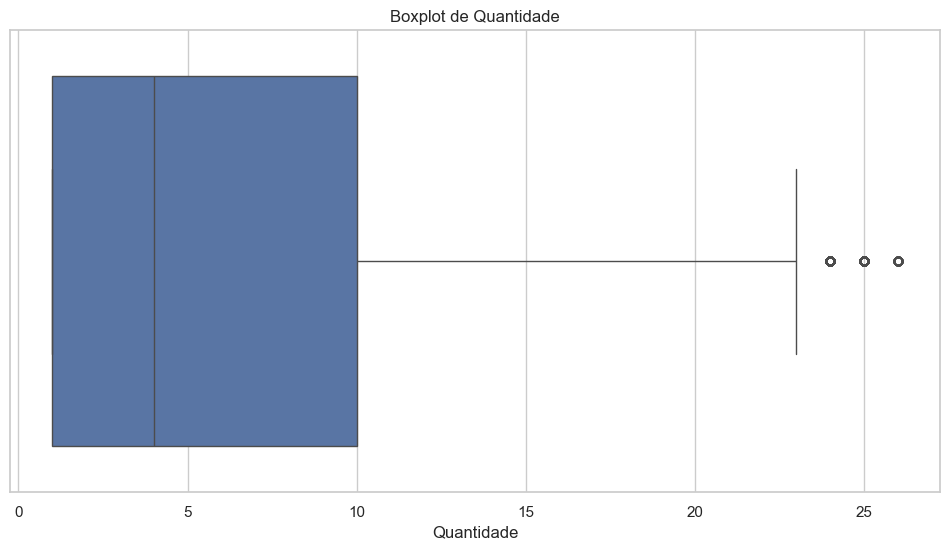

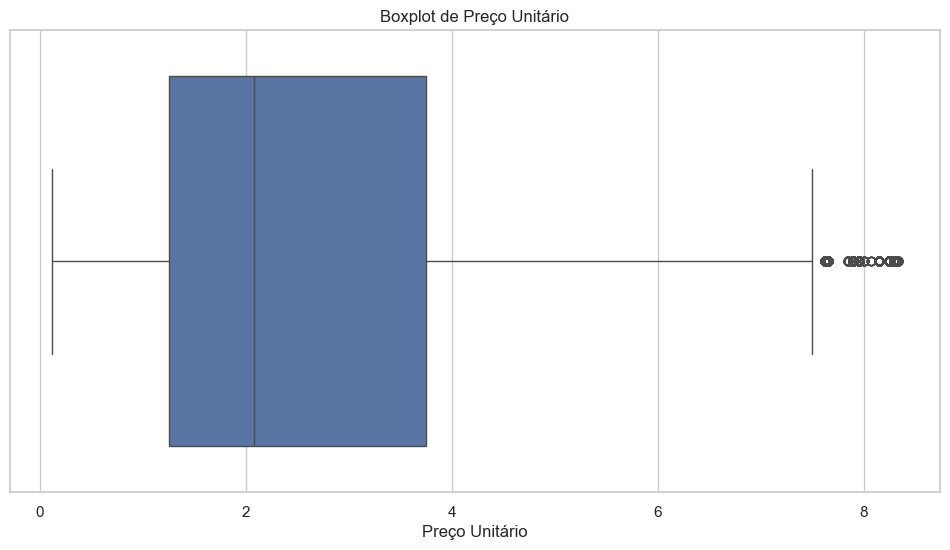

In [23]:
# Visualização de outliers na coluna Quantidade
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['Quantidade'])
plt.title('Boxplot de Quantidade')
plt.xlabel('Quantidade')
plt.show()

# Visualização de outliers na coluna PrecoUnitario
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['PrecoUnitario'])
plt.title('Boxplot de Preço Unitário')
plt.xlabel('Preço Unitário')
plt.show()

#### Observamos que após o tratamento de outliers, agora, nosso conjunto de dados parece estar mais equilibrado, representando valores mais realistas e de acordo com o modelo de negócio.

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460163 entries, 0 to 460162
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   NumeroFatura   460163 non-null  object 
 1   CodigoProduto  460163 non-null  object 
 2   Descricao      460163 non-null  object 
 3   Quantidade     460163 non-null  int64  
 4   DataFatura     460163 non-null  object 
 5   PrecoUnitario  460163 non-null  float64
 6   IDCliente      460163 non-null  object 
 7   Pais           460163 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 28.1+ MB


# 7. Processamento de Texto nas Descrições dos Produtos

In [25]:
# Aplicar a função de limpeza às descrições
df['DescricaoLimpa'] = df['Descricao'].apply(limpar_descricao)


In [26]:
# Vetorização usando TF-IDF
vectorizer = TfidfVectorizer(stop_words=stop_words_en, max_features=5000)
X = vectorizer.fit_transform(df['DescricaoLimpa'])


In [27]:
# Redução de dimensionalidade para otimizar análises
svd = TruncatedSVD(n_components=50, random_state=42)
X_reduced = svd.fit_transform(X)


##### Elbow Method

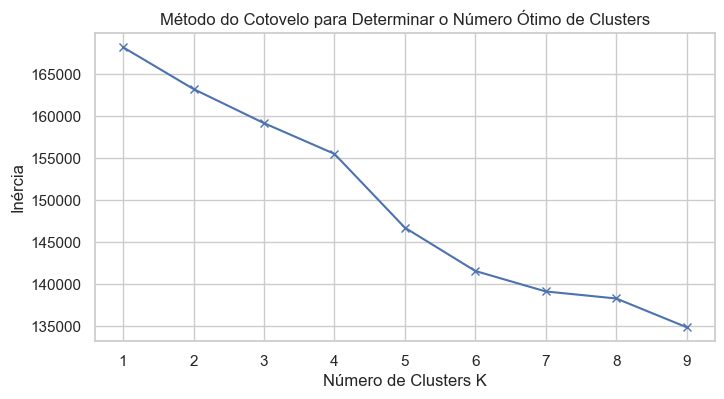

In [28]:
# Lista para armazenar o erro quadrático médio (inertia)
inertias = []

# Testar k de 1 a 9
K = range(1, 10)

for k in K:
    mbkmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1000)
    mbkmeans.fit(X_reduced)
    inertias.append(mbkmeans.inertia_)

# Plotar o gráfico do método do cotovelo
plt.figure(figsize=(8, 4))
plt.plot(K, inertias, 'bx-')
plt.xlabel('Número de Clusters K')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo para Determinar o Número Ótimo de Clusters')
plt.show()


##### Silhouette Score

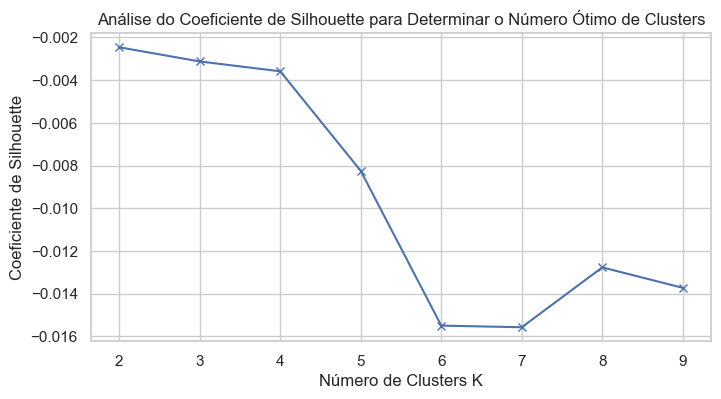

In [29]:
# Definindo a amostra
sample_size = 10000  
X_sample = X_reduced[np.random.choice(X_reduced.shape[0], sample_size, replace=False)]

# Lista para armazenar os scores de silhouette
silhouette_scores = []

# Intervalo de K para teste
K = range(2, 10)

# Loop para calcular silhouette para diferentes K
for k in K:
    mbkmeans = MiniBatchKMeans(
        n_clusters=k, 
        random_state=42, 
        batch_size=2000,  # Batch maior para acelerar
        max_iter=100,  # Limitar iterações
        tol=1e-3  # Ajuste de tolerância
    )
    
    # Ajustando e obtendo os rótulos dos clusters
    cluster_labels = mbkmeans.fit_predict(X_reduced)
    
    # Calculando o coeficiente de silhouette com paralelização e amostra
    silhouette_avg = silhouette_score(X_sample, cluster_labels[:sample_size], n_jobs=-1)
    silhouette_scores.append(silhouette_avg)

# Plotando o gráfico do coeficiente de silhouette
plt.figure(figsize=(8, 4))
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Número de Clusters K')
plt.ylabel('Coeficiente de Silhouette')
plt.title('Análise do Coeficiente de Silhouette para Determinar o Número Ótimo de Clusters')
plt.show()

##### Nota: A escolha de 5 clusters ocorreu devido a um equilibrio entre os dois métodos acima e também quanto à necessidade do negócio.

In [30]:
# Aplicar o MiniBatchKMeans com o número escolhido de clusters
num_clusters = 5
kmeans_final = MiniBatchKMeans(n_clusters=num_clusters, random_state=42, batch_size=1000)
df['Cluster'] = kmeans_final.fit_predict(X_reduced)


In [31]:
# Analisar cada cluster
for cluster_num in range(num_clusters):
    print(f"\nCluster {cluster_num}:")
    descricoes_cluster = df[df['Cluster'] == cluster_num]['DescricaoLimpa']
    palavras_comuns = palavras_mais_comuns(descricoes_cluster)
    print(f"Palavras mais comuns no Cluster {cluster_num}: {palavras_comuns}")



Cluster 0:
Palavras mais comuns no Cluster 0: [('set', 49556), ('red', 25054), ('box', 22365), ('retrospot', 21358), ('vintage', 20484), ('pink', 20262), ('christmas', 18368), ('metal', 17686), ('design', 16675), ('cake', 16672), ('sign', 15930), ('card', 14727), ('blue', 14503), ('pack', 13852), ('tin', 13801)]

Cluster 1:
Palavras mais comuns no Cluster 1: [('holder', 11929), ('tlight', 11343), ('hanging', 6441), ('heart', 5967), ('glass', 3327), ('white', 2136), ('zinc', 1716), ('silver', 1455), ('star', 1212), ('popcorn', 1200), ('colour', 1109), ('jar', 1019), ('card', 969), ('victorian', 873), ('antique', 865)]

Cluster 2:
Palavras mais comuns no Cluster 2: [('heart', 34011), ('decoration', 11679), ('bottle', 8425), ('hot', 8417), ('water', 8330), ('white', 6621), ('wicker', 6002), ('small', 4773), ('hanging', 4737), ('wooden', 4732), ('large', 4176), ('set', 4052), ('pink', 2775), ('love', 2708), ('frame', 2544)]

Cluster 3:
Palavras mais comuns no Cluster 3: [('dolly', 7370), 

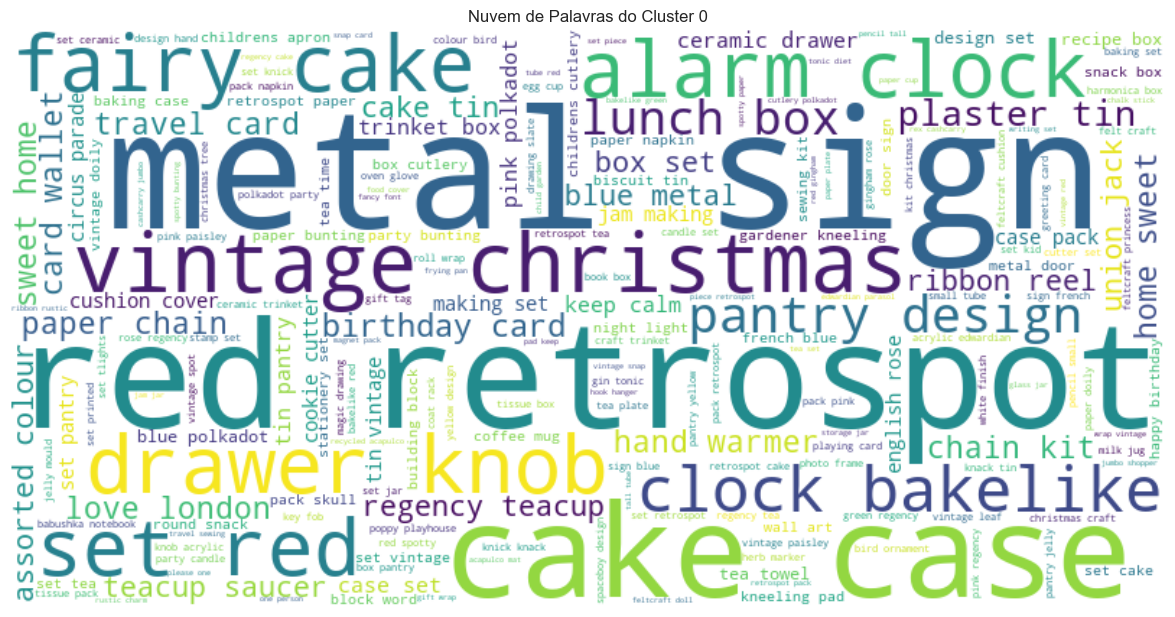

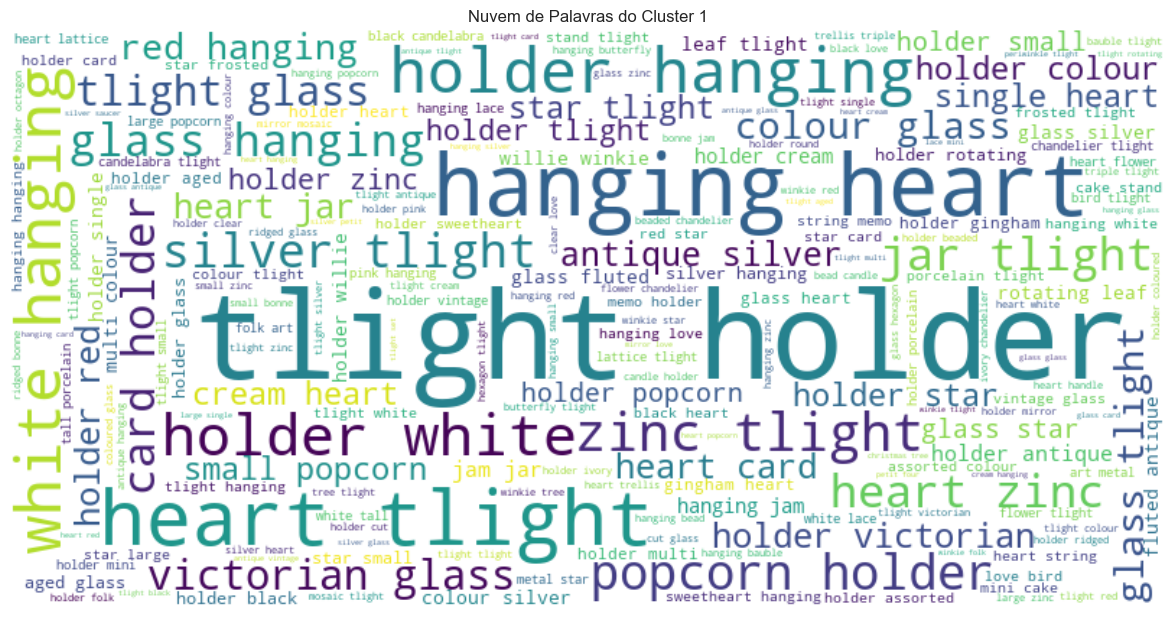

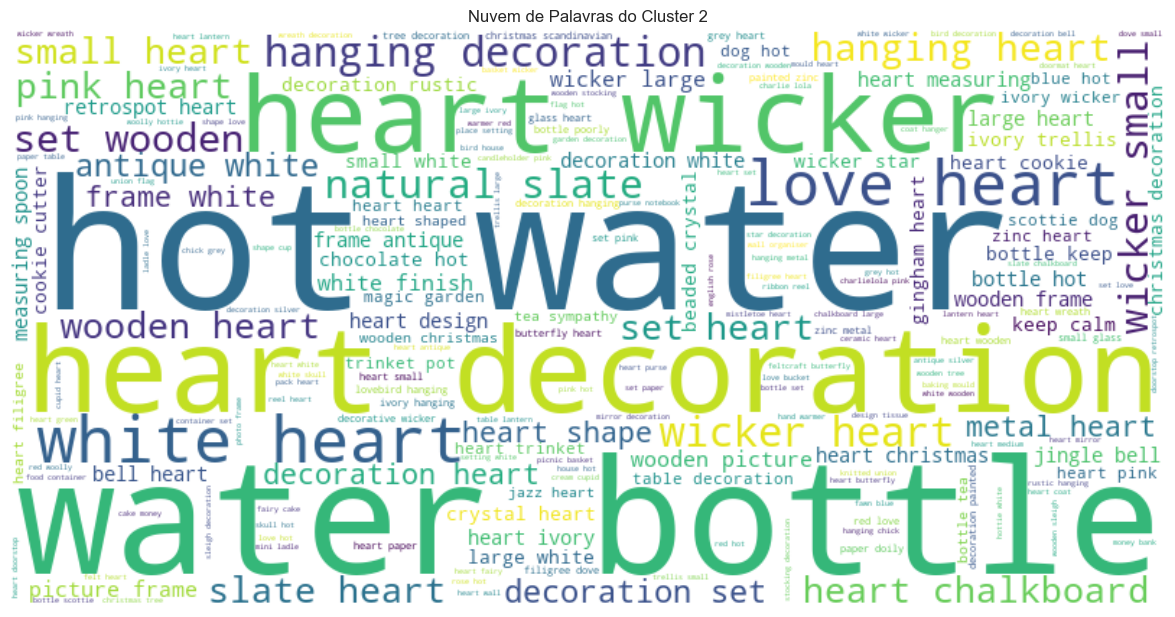

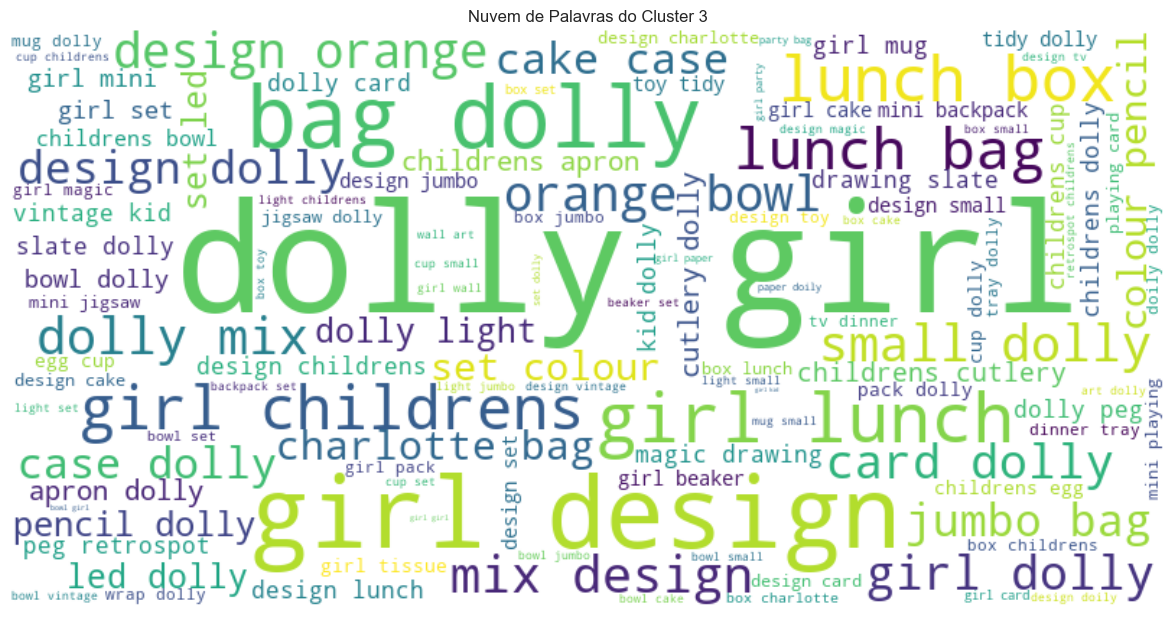

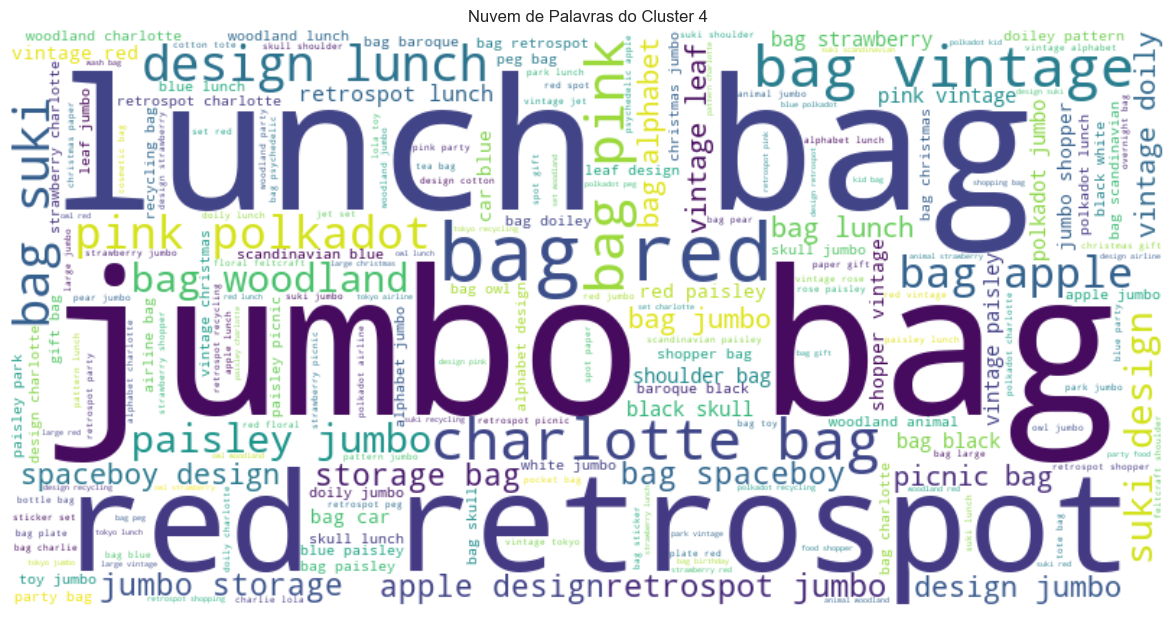

In [32]:
# Criar nuvens de palavras
for cluster_num in range(num_clusters):
    palavras = ' '.join(df[df['Cluster'] == cluster_num]['DescricaoLimpa'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(palavras)
    plt.figure(figsize=(15, 7.5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Nuvem de Palavras do Cluster {cluster_num}')
    plt.show()


In [33]:
# Verificar se a coluna 'Cluster' existe no DataFrame
if 'Cluster' in df.columns:
    # Definir o mapeamento dos clusters para categorias
    cluster_to_categoria = {
        0: 'Decoração e Artigos Temáticos',  
        1: 'Relógios e Acessórios para Viagem',  
        2: 'Bolsas e Sacolas',  
        3: 'Acessórios para Almoço e Cozinha',  
        4: 'Decoração com Velas e Acessórios Românticos'  
    }
    
    # Mapear a coluna 'Cluster' para a nova coluna 'CategoriaProduto'
    df['CategoriaProduto'] = df['Cluster'].map(cluster_to_categoria)
else:
    print("A coluna 'Cluster' não existe no DataFrame.")





In [34]:
# Contagem de produtos por categoria
df['CategoriaProduto'].value_counts()


CategoriaProduto
Decoração e Artigos Temáticos                  344613
Bolsas e Sacolas                                51108
Decoração com Velas e Acessórios Românticos     43376
Relógios e Acessórios para Viagem               13683
Acessórios para Almoço e Cozinha                 7383
Name: count, dtype: int64

#### Nota: Após os tratamentos acima, agora possuímos uma coluna CategoriaProduto, onde encontramos 5 categorias com base nas palavras mais relacionadas à cada cluster.

In [35]:
# Função para categorizar o preço
def categorizar_preco(preco):
    if preco <= 5:
        return 'Barato'
    elif 5 < preco <= 20:
        return 'Moderado'
    else:
        return 'Caro'

# Aplicar a função
df['CategoriaPreco'] = df['PrecoUnitario'].apply(categorizar_preco)



In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460163 entries, 0 to 460162
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   NumeroFatura      460163 non-null  object 
 1   CodigoProduto     460163 non-null  object 
 2   Descricao         460163 non-null  object 
 3   Quantidade        460163 non-null  int64  
 4   DataFatura        460163 non-null  object 
 5   PrecoUnitario     460163 non-null  float64
 6   IDCliente         460163 non-null  object 
 7   Pais              460163 non-null  object 
 8   DescricaoLimpa    460163 non-null  object 
 9   Cluster           460163 non-null  int32  
 10  CategoriaProduto  460163 non-null  object 
 11  CategoriaPreco    460163 non-null  object 
dtypes: float64(1), int32(1), int64(1), object(9)
memory usage: 40.4+ MB


In [37]:
# Converter 'DataFatura' para datetime e tratar erros
df['DataFatura'] = pd.to_datetime(df['DataFatura'], errors='coerce')

# Criar colunas temporais adicionais (Ano, Mês, Dia, etc.)
df['Ano'] = df['DataFatura'].dt.year
df['Mes'] = df['DataFatura'].dt.month
df['Dia'] = df['DataFatura'].dt.day
df['DiaSemana'] = df['DataFatura'].dt.weekday
df['SemanaAno'] = df['DataFatura'].dt.isocalendar().week

# Converter IDs e identificadores para strings (tratando valores faltantes e formatando)
df['NumeroFatura'] = df['NumeroFatura'].astype(str)
df['CodigoProduto'] = df['CodigoProduto'].astype(str)
df['IDCliente'] = df['IDCliente'].fillna('').astype(str).str.replace(r'\.0$', '', regex=True)

# Remover colunas irrelevantes ('Cluster', 'DescricaoLimpa', 'DiasDesdeUltimaCompra')
df = df.drop(columns=['Cluster', 'DescricaoLimpa', 'DiasDesdeUltimaCompra'], errors='ignore')

# Converter 'PrecoUnitario' para numérico e tratar NaNs
df['PrecoUnitario'] = pd.to_numeric(df['PrecoUnitario'], errors='coerce').fillna(0).round(2)

# Criar a feature 'ValorTotalFatura' (Quantidade * PrecoUnitario) e formatar com dois dígitos após o ponto
df['ValorTotalFatura'] = (df['Quantidade'] * df['PrecoUnitario']).round(2).apply(lambda x: f"{x:.2f}")

# Verificar se cada linha representa uma transação individual
print(df.head())

# Converter colunas categóricas para 'category'
categorical_columns = ['CategoriaProduto', 'CategoriaPreco']
for col in categorical_columns:
    df[col] = df[col].astype('category')

#  Adicionar a coluna 'FaturaUnica' para identificar clientes com uma única fatura
df['FaturaUnica'] = df.groupby('IDCliente')['NumeroFatura'].transform('nunique') == 1

#  Substituir valores infinitos por NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Exibir informações finais do DataFrame
print(df.info())
print(df.head())

# Definir o caminho do arquivo para salvar
output_file = "data/processed/transacoes_final.csv"

# Salvar o DataFrame df como CSV no caminho especificado
df.to_csv(output_file, index=False)

print(f"Arquivo '{output_file}' criado com sucesso!")



  NumeroFatura CodigoProduto                            Descricao  Quantidade  \
0       536365        85123A   WHITE HANGING HEART T-LIGHT HOLDER           6   
1       536365         71053                  WHITE METAL LANTERN           6   
2       536365        84406B       CREAM CUPID HEARTS COAT HANGER           8   
3       536365        84029G  KNITTED UNION FLAG HOT WATER BOTTLE           6   
4       536365        84029E       RED WOOLLY HOTTIE WHITE HEART.           6   

           DataFatura  PrecoUnitario IDCliente            Pais  \
0 2010-12-01 08:26:00           2.55     17850  United Kingdom   
1 2010-12-01 08:26:00           3.39     17850  United Kingdom   
2 2010-12-01 08:26:00           2.75     17850  United Kingdom   
3 2010-12-01 08:26:00           3.39     17850  United Kingdom   
4 2010-12-01 08:26:00           3.39     17850  United Kingdom   

                    CategoriaProduto CategoriaPreco   Ano  Mes  Dia  \
0  Relógios e Acessórios para Viagem         

# **Configuração do Dataset Final**

## **1. Conversão de Colunas Temporais**
- A coluna `DataFatura` foi convertida para o formato `datetime` para facilitar operações e análises baseadas no tempo.
- Foram criadas colunas adicionais: 
  - **Ano:** Ano da compra.
  - **Mês:** Mês da compra.
  - **Dia:** Dia do mês.
  - **DiaSemana:** Dia da semana.
  - **SemanaAno:** Semana correspondente no ano.

---

## **2. Limpeza e Formatação de Dados**
- As colunas desnecessárias foram removidas, como `DescricaoLimpa` e `Cluster`.
- Os IDs e identificadores (como `NumeroFatura`, `CodigoProduto` e `IDCliente`) foram convertidos para strings para garantir a consistência dos dados.
- A coluna `PrecoUnitario` foi convertida para valores numéricos e arredondada para duas casas decimais.

---

## **3. Criação da Coluna de Valor Total**
- **ValorTotalVendas:** Calculado como `Quantidade * PrecoUnitario` para cada transação individual.  
- A precisão foi mantida com arredondamento para duas casas decimais.

---

## **4. Identificação de Compras Únicas**
- **FaturaUnica:** Coluna booleana que indica se a transação pertence a uma fatura única, ajudando a identificar clientes com comportamento de compra específico.

---

## **5. Configuração do Dataset para Análises Temporais e Clusters**
- O dataset está estruturado para permitir:
  - **Análises temporais** baseadas nas colunas de data e tempo.
  - **Clusterização e segmentação** de clientes utilizando variáveis como `ValorTotalVendas`, categorias de produto e país.

---

## **6. Salvar o Dataset Final**
- O dataset limpo e configurado será salvo como `transacoes_final.csv` para ser utilizado nas próximas etapas de análise e modelagem.



